In [16]:

from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import pickle

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
true = pd.read_csv(r"True1.csv")
fake = pd.read_csv(r"Fake1.csv")

true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
true["target"] = 0
fake["target"] = 1

true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [5]:
df = pd.concat([true,fake])
df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
print(len(true) + len(fake))
print(len(df))

44898
44898


In [7]:
import pandas as pd

# Assuming df is your DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,title,text,subject,date,target
0,Factbox: Contenders for key jobs in Trump's ad...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"November 22, 2016",0
1,"At North Korea's doorstep, Trump warns of U.S....",SEOUL (Reuters) - President Donald Trump on Tu...,worldnews,"November 6, 2017",0
2,VP PENCE OUTRAGED! The Associated Press Publis...,,politics,"Mar 5, 2017",1
3,TOMI LAHREN’S Rant Against Anti-Trump Rioters ...,Share this with every offended snowflake in Am...,left-news,"Nov 14, 2016",1
4,"As U.S. ban on travel to North Korea kicks in,...",(This Aug 31 story corrects location of Burkh...,worldnews,"August 31, 2017",0


In [8]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Preprocessing

In [9]:
def basic_text_cleaning(line_from_column):
    # This function takes in a string, not a list or an array for the arg line_from_column
    
    tokenized_doc = word_tokenize(line_from_column)
    
    new_review = []
    for token in tokenized_doc:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_review.append(new_token)
    
    new_term_vector = []
    for word in new_review:
        if not word in stopwords.words('english'):
            new_term_vector.append(word)
    
    final_doc = []
    for word in new_term_vector:
        final_doc.append(wordnet.lemmatize(word))
    
    return ' '.join(final_doc)

def get_dummies(df, col_target):
    df_y = pd.get_dummies(df[col_target])
    df_new = df.join(df_y)
    df_new = df_new.drop(col_target,axis=1)
    return df_new

def prep_features(df, labels, text):
    y = df[labels].values
    comments_train = df[text]
    comments_train = list(comments_train)
    
    return comments_train, y

def prep_tokenizer(texts,MAX_NB_WORDS):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    
    print("Tokeniser created - Saving Tokeniser")
    
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print("Tokeniser saved")
    
def prepare_training_test_data(texts,tokenizer,y):
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Vocabulary size:', len(word_index))
    
    print("Padding sequences")
    
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', data.shape)
    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = y[indices]
    
    num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
    x_train = data[: -num_validation_samples]
    y_train = labels[: -num_validation_samples]
    x_val = data[-num_validation_samples: ]
    y_val = labels[-num_validation_samples: ]
    
    print('Number of entries in each category:')
    print('training: ', y_train.sum(axis=0))
    print('validation: ', y_val.sum(axis=0))
    
    print('Tokenized sentences: \n', data[0])
    print('One hot label: \n', labels[0])
    
    return x_train, y_train, x_val, y_val

In [10]:
wordnet = WordNetLemmatizer()
regex = re.compile('[%s]' % re.escape(string.punctuation))

In [11]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100   
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [12]:
df = df[["text","target"]]
df.head()

,text,target
0,(Reuters) - U.S. President-elect Donald Trump ...,0
1,SEOUL (Reuters) - President Donald Trump on Tu...,0
2,,1
3,Share this with every offended snowflake in Am...,1
4,(This Aug 31 story corrects location of Burkh...,0


In [13]:
from tqdm.notebook import tqdm

# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# Apply the function to the DataFrame
df["clean_text"] = df["text"].progress_apply(basic_text_cleaning)
df.head()


  0%|          | 0/44898 [00:00<?, ?it/s]

,text,target,clean_text
0,(Reuters) - U.S. President-elect Donald Trump ...,0,Reuters US Presidentelect Donald Trump held ad...
1,SEOUL (Reuters) - President Donald Trump on Tu...,0,SEOUL Reuters President Donald Trump Tuesday w...
2,,1,
3,Share this with every offended snowflake in Am...,1,Share every offended snowflake America clamori...
4,(This Aug 31 story corrects location of Burkh...,0,This Aug 31 story corrects location Burkhead h...


In [21]:
import nltk
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


False

In [18]:
import nltk
nltk.download('wordnet')



[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


False

In [22]:
df.to_csv("clean_news.csv")

In [17]:
df = pd.read_csv(r"clean_news.csv")
df["clean_text"]=df["clean_text"].astype(str)

In [23]:
len(df)

44898

In [24]:
df_labels =  pd.get_dummies(df["target"])
len(df_labels)

44898

In [25]:
df_labels = df_labels.reset_index()

In [26]:
df = df.reset_index()

In [27]:
df.head()

,index,text,target,clean_text
0,0,(Reuters) - U.S. President-elect Donald Trump ...,0,Reuters US Presidentelect Donald Trump held ad...
1,1,SEOUL (Reuters) - President Donald Trump on Tu...,0,SEOUL Reuters President Donald Trump Tuesday w...
2,2,,1,
3,3,Share this with every offended snowflake in Am...,1,Share every offended snowflake America clamori...
4,4,(This Aug 31 story corrects location of Burkh...,0,This Aug 31 story corrects location Burkhead h...


In [28]:
df = df.drop("index",axis=1)

In [29]:
df.head()

,text,target,clean_text
0,(Reuters) - U.S. President-elect Donald Trump ...,0,Reuters US Presidentelect Donald Trump held ad...
1,SEOUL (Reuters) - President Donald Trump on Tu...,0,SEOUL Reuters President Donald Trump Tuesday w...
2,,1,
3,Share this with every offended snowflake in Am...,1,Share every offended snowflake America clamori...
4,(This Aug 31 story corrects location of Burkh...,0,This Aug 31 story corrects location Burkhead h...


In [30]:
df_labels =  pd.get_dummies(df["target"])
df_labels = df_labels.reset_index()
df_labels = df_labels.drop("index",axis=1)
df_labels.head()

,0,1
0,True,False
1,True,False
2,False,True
3,False,True
4,True,False


In [31]:
df_new =df.join(df_labels)

In [32]:
df_new = get_dummies(df=df, col_target="target")
df_new.head()

,text,clean_text,0,1
0,(Reuters) - U.S. President-elect Donald Trump ...,Reuters US Presidentelect Donald Trump held ad...,True,False
1,SEOUL (Reuters) - President Donald Trump on Tu...,SEOUL Reuters President Donald Trump Tuesday w...,True,False
2,,,False,True
3,Share this with every offended snowflake in Am...,Share every offended snowflake America clamori...,False,True
4,(This Aug 31 story corrects location of Burkh...,This Aug 31 story corrects location Burkhead h...,True,False


In [33]:
len(df_new)

44898

In [34]:
labels = [0,1]
x_train, y_train = prep_features(df=df_new, labels=[0,1], text="clean_text")
print(x_train[0])
print(y_train[0])

Reuters US Presidentelect Donald Trump held additional meeting New York Tuesday worked fill administration position ahead inauguration Jan 20 Below people mentioned contender senior role See end list post already filled Steven Mnuchin former Goldman Sachs Group Inc executive Trump ’ campaign finance chairman Jeb Hensarling Republican US representative Texas chairman House Financial Services Committee Jamie Dimon JPMorgan Chase Co chief executive officer Tom Barrack founder chairman Colony Capital Inc Jonathan Gray global head real estate Blackstone Group Mitt Romney 2012 Republican presidential nominee former Massachusetts governor Rudy Giuliani former Republican mayor New York City Nikki Haley Republican governor South Carolina John Bolton former US ambassador United Nations Republican President George W Bush Bob Corker Republican US senator Tennessee chairman Senate Foreign Relations Committee Zalmay Khalilzad former US ambassador Iraq James Mattis retired Marine general David Petrae

In [37]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [36]:
pip install --upgrade keras-preprocessing


     ---------------------------------------- 0.0/42.6 kB ? eta -:--:--
     --------- ------------------------------ 10.2/42.6 kB ? eta -:--:--
     ------------------ ------------------- 20.5/42.6 kB 131.3 kB/s eta 0:00:01
     ------------------ ------------------- 20.5/42.6 kB 131.3 kB/s eta 0:00:01
     ------------------ ------------------- 20.5/42.6 kB 131.3 kB/s eta 0:00:01
     --------------------------- ---------- 30.7/42.6 kB 119.1 kB/s eta 0:00:01
     -------------------------------------- 42.6/42.6 kB 137.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
x_train,y_train,x_test,y_test = prepare_training_test_data(texts=x_train,tokenizer=tokenizer,y=y_train)

Vocabulary size: 208476
Padding sequences
Shape of data tensor: (44898, 200)
Number of entries in each category:
training:  [17115 18804]
validation:  [4302 4677]
Tokenized sentences: 
 [   47    17    21   758   831   550   481  6314   100   328   388  1980
   147    23    80  2687  3312  5110  2204   633   209     1  2388     8
   135  2208  3685   107     4   766   822     9   481    27   316    87
   225  2388  8203    73   771   112    91    80     4   189   229   131
   209     6     8  1183 11936   209     4   229   177     9     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

In [54]:
GLOVE_DIR = r'C:\Users\DELL\Desktop\BTP\glove.6B.100d.txt'

embeddings_index = {}
word_index = tokenizer.word_index
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: C:\Users\DELL\Desktop\BTP\glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [55]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [56]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="sigmoid")(x)

In [57]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 100)          20847700  
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d (Glob  (None, 60)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                            

In [58]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [89]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_test, y_test))

Training progress:
Epoch 1/20
1123/1123 [==============================] - 61s 54ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0198 - val_accuracy: 0.9959
Epoch 2/20
1123/1123 [==============================] - 91s 81ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0172 - val_accuracy: 0.9960
Epoch 3/20
1123/1123 [==============================] - 115s 102ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0148 - val_accuracy: 0.9959
Epoch 4/20
1123/1123 [==============================] - 111s 99ms/step - loss: 9.0245e-04 - accuracy: 0.9997 - val_loss: 0.0176 - val_accuracy: 0.9964
Epoch 5/20
1123/1123 [==============================] - 70s 62ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0205 - val_accuracy: 0.9963
Epoch 6/20
1123/1123 [==============================] - 68s 60ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0185 - val_accuracy: 0.9961
Epoch 7/20
1123/1123 [==============================] - 74s 66ms/step - loss: 0.0017 - accuracy: 0

In [60]:
model.save("LSTM_model_1.h5")

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [62]:
import matplotlib.pyplot as plt

In [63]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


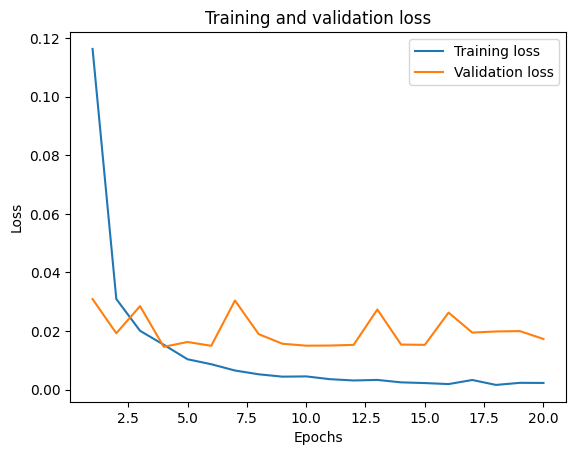

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [65]:
def predict(model,i):
    clean_text =[]
    i = basic_text_cleaning(i)
    clean_text.append(i)
    sequences = tokenizer.texts_to_sequences(clean_text)
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    pred = model.predict(data)
    return pred

In [66]:
test = "Facebook Inc will allow employees participating in the protest to take the time off without drawing down their vacation days, spokesman Andy Stone said. Separately, online therapy company Talkspace said it ended partnership discussions with Facebook. Talkspace CEO Oren Frank tweeted he would “not support a platform that incites violence, racism, and lies.”"

In [82]:
from tensorflow.keras.models import load_model

model_new = load_model("LSTM_model_1.h5")


In [83]:
predict(model=model_new,i=test)[0][0]

1/1 [==============================] - 0s 383ms/step


0.9934127

In [84]:
model.predict(x_test)

281/281 [==============================] - 4s 14ms/step


array([[1.0000000e+00, 1.2260679e-10],
       [1.0000000e+00, 1.3427808e-11],
       [1.6323315e-06, 9.9999857e-01],
       ...,
       [1.0000000e+00, 2.3103479e-12],
       [9.9999988e-01, 1.8686505e-07],
       [1.1926293e-06, 9.9999857e-01]], dtype=float32)

In [85]:
x_test[2]

array([  950,  1499,    91,   295,   705,  2596,  1039,   826,    12,
        4611,  3425,   358, 17953,   845,  3069,  2956, 14266,   311,
          53,    12,  1098, 22645, 13684,  1021,   174,  3425,  1702,
        4863,   196,   845,  3069,  5475,  2493,  1229, 83374,  1499,
         103,   303,    60,   561,  1413, 13684,   533,    98,  1499,
        7188, 13684, 15059,   207, 61788,  1274,   845,  3069,   830,
       52607,   314,   604, 13684,   705,    76,  1340,   869,    12,
         146,  2740, 38512,  2318,   177,    28,   990,  6330,   759,
        5475,    12,  1098,  2897, 11489,  4647,    21,    76,   113,
        2956,  2259,    19,  6962,   652,    39,  2559,    11,  1499,
           6,  4769,  1027,  3754,   119,   291,   161,  1027,   498,
         261,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [86]:
y_classes = predict(model=model,i=test).argmax(axis=-1)

1/1 [==============================] - 0s 24ms/step


In [87]:
y_classes[0]

0

In [88]:
from tensorflow.keras.models import load_model
model_new = load_model("LSTM_model_1.h5")